In [1]:
import os
from data_loader import *

C:\Users\cb102\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from prostate_seg import *
import torch
# import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss, L1Loss
import time
from tqdm import tqdm
from torchvision import transforms
from sklearn.model_selection import train_test_split
import config
import matplotlib.pyplot as plt
import argparse

In [3]:
print("Torch version: {}".format(torch.__version__))
print(torch.cuda.is_available())

Torch version: 1.10.1
True


#### Loading & Initializing variables

In [4]:
loader = path_loader()
loader.get_path(config.DATASET_MAIN_BRUNCH)
(im_path, mask_path) = loader.load_path()
DEVICE = config.DEVICE
THRESHOLD = config.THRESHOLD
split = train_test_split(im_path,mask_path,test_size=config.TEST_SPLIT,random_state = config.RAND_STATE)
train_paths_Images,test_paths_Images,train_paths_Masks,test_paths_Masks = split[0],split[1],split[2],split[3]

In [5]:
train = dataset_preperation(train_paths_Images, train_paths_Masks, True)
train_dataset = train.read_preprocess_dicom_mask(True)

Loading and Processing datasets for Training...
...


134it [01:46,  1.25it/s]

Loading images and masks finished.
Loading augmented images and masks finished.
Augmentation: shift pics left and right by 5 pixels. 
Rotate pics by 90 and 270 degrees
Total amount of samples: 536
...


In [6]:
test = dataset_preperation(test_paths_Images,test_paths_Masks,False)
test_dataset = test.read_preprocess_dicom_mask(True)

Loading and Processing datasets for Testing...
...


67it [00:51,  1.31it/s]

Loading images and masks finished.
Total amount of samples: 67
...


In [7]:
train_imgs, train_mask = train_dataset[0],train_dataset[1]
test_imgs, test_mask = test_dataset[0],test_dataset[1]

In [8]:
transformation = transforms.Compose([transforms.ToPILImage(),
                            transforms.ToTensor()])
_train = FetchImage(train_imgs,train_mask,transformation)
_test = FetchImage(test_imgs, test_mask, transformation)

In [9]:
train_Loader = DataLoader(_train,shuffle = True, batch_size = config.BATCH_SIZE,
                          pin_memory = config.PIN_MEMORY,num_workers = 4)
test_Loader = DataLoader(_test, shuffle=True, batch_size=config.BATCH_SIZE,
                          pin_memory=config.PIN_MEMORY,num_workers = 4)

In [10]:
unet = U_net().to(DEVICE)
BEC_Loss = BCEWithLogitsLoss()
L1_Loss = L1Loss()
opt = Adam(unet.parameters(), lr=config.INIT_LR,weight_decay = config.WEIGHT_DECAY)
trainSteps = len(train_paths_Images) // config.BATCH_SIZE
testSteps = len(test_paths_Images) // config.BATCH_SIZE

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
print(torch.cuda.memory_reserved())

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Running on epoch 0...


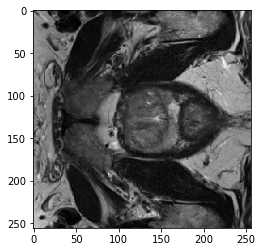

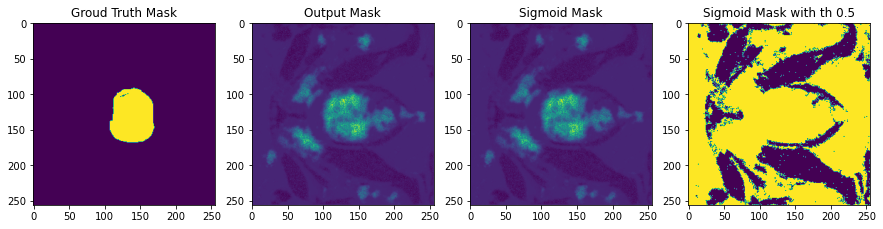

  1%|▊                                                                                 | 1/100 [00:33<55:12, 33.46s/it]


[INFO] EPOCH: 1/100
Train loss: 3.117968, Test loss: 0.9242


  2%|█▋                                                                                | 2/100 [01:03<51:17, 31.41s/it]


[INFO] EPOCH: 2/100
Train loss: 3.115260, Test loss: 0.9243


  3%|██▍                                                                               | 3/100 [01:33<49:42, 30.75s/it]


[INFO] EPOCH: 3/100
Train loss: 3.113959, Test loss: 0.9243


  4%|███▎                                                                              | 4/100 [02:03<48:39, 30.42s/it]


[INFO] EPOCH: 4/100
Train loss: 3.112867, Test loss: 0.9243


  5%|████                                                                              | 5/100 [02:33<47:55, 30.27s/it]


[INFO] EPOCH: 5/100
Train loss: 3.111695, Test loss: 0.9243


  6%|████▉                                                                             | 6/100 [03:03<47:14, 30.16s/it]


[INFO] EPOCH: 6/100
Train loss: 3.110439, Test loss: 0.9242


  7%|█████▋                                                                            | 7/100 [03:33<46:38, 30.09s/it]


[INFO] EPOCH: 7/100
Train loss: 3.109027, Test loss: 0.9242


  8%|██████▌                                                                           | 8/100 [04:02<45:57, 29.97s/it]


[INFO] EPOCH: 8/100
Train loss: 3.107833, Test loss: 0.9241


  9%|███████▍                                                                          | 9/100 [04:32<45:17, 29.86s/it]


[INFO] EPOCH: 9/100
Train loss: 3.106259, Test loss: 0.9242


 10%|████████                                                                         | 10/100 [05:02<44:49, 29.88s/it]


[INFO] EPOCH: 10/100
Train loss: 3.104228, Test loss: 0.9237


 11%|████████▉                                                                        | 11/100 [05:32<44:15, 29.83s/it]


[INFO] EPOCH: 11/100
Train loss: 3.102138, Test loss: 0.9237


 12%|█████████▋                                                                       | 12/100 [06:01<43:43, 29.82s/it]


[INFO] EPOCH: 12/100
Train loss: 3.100302, Test loss: 0.9238


 13%|██████████▌                                                                      | 13/100 [06:31<43:11, 29.79s/it]


[INFO] EPOCH: 13/100
Train loss: 3.098119, Test loss: 0.9233


 14%|███████████▎                                                                     | 14/100 [07:01<42:41, 29.79s/it]


[INFO] EPOCH: 14/100
Train loss: 3.096375, Test loss: 0.9232


 15%|████████████▏                                                                    | 15/100 [07:32<42:32, 30.03s/it]


[INFO] EPOCH: 15/100
Train loss: 3.093391, Test loss: 0.9227


 16%|████████████▉                                                                    | 16/100 [08:02<42:09, 30.11s/it]


[INFO] EPOCH: 16/100
Train loss: 3.090692, Test loss: 0.9236


 17%|█████████████▊                                                                   | 17/100 [08:32<41:42, 30.15s/it]


[INFO] EPOCH: 17/100
Train loss: 3.087757, Test loss: 0.9231


 18%|██████████████▌                                                                  | 18/100 [09:02<41:03, 30.05s/it]


[INFO] EPOCH: 18/100
Train loss: 3.084361, Test loss: 0.9233


 19%|███████████████▍                                                                 | 19/100 [09:32<40:26, 29.95s/it]


[INFO] EPOCH: 19/100
Train loss: 3.081789, Test loss: 0.9224


 20%|████████████████▏                                                                | 20/100 [10:02<40:11, 30.15s/it]


[INFO] EPOCH: 20/100
Train loss: 3.079257, Test loss: 0.9221
Running on epoch 20...


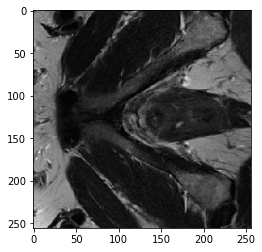

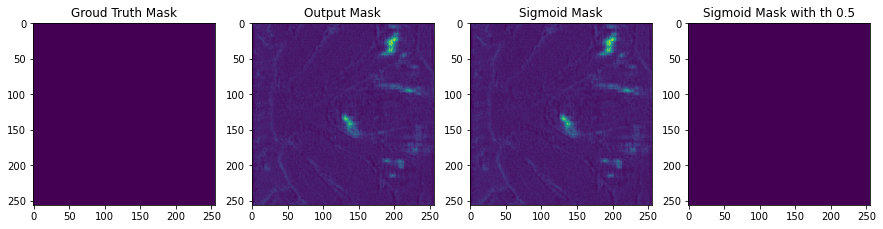

 21%|█████████████████                                                                | 21/100 [10:34<40:18, 30.61s/it]


[INFO] EPOCH: 21/100
Train loss: 3.075352, Test loss: 0.9217


 22%|█████████████████▊                                                               | 22/100 [11:04<39:44, 30.57s/it]


[INFO] EPOCH: 22/100
Train loss: 3.071369, Test loss: 0.9207


 23%|██████████████████▋                                                              | 23/100 [11:35<39:04, 30.44s/it]


[INFO] EPOCH: 23/100
Train loss: 3.067710, Test loss: 0.9208


 24%|███████████████████▍                                                             | 24/100 [12:04<38:13, 30.17s/it]


[INFO] EPOCH: 24/100
Train loss: 3.064254, Test loss: 0.9194


 25%|████████████████████▎                                                            | 25/100 [12:34<37:34, 30.06s/it]


[INFO] EPOCH: 25/100
Train loss: 3.059386, Test loss: 0.9215


 26%|█████████████████████                                                            | 26/100 [13:04<36:57, 29.97s/it]


[INFO] EPOCH: 26/100
Train loss: 3.056409, Test loss: 0.9219


 27%|█████████████████████▊                                                           | 27/100 [13:34<36:27, 29.96s/it]


[INFO] EPOCH: 27/100
Train loss: 3.052134, Test loss: 0.9221


 28%|██████████████████████▋                                                          | 28/100 [14:04<36:05, 30.07s/it]


[INFO] EPOCH: 28/100
Train loss: 3.047489, Test loss: 0.9200


 29%|███████████████████████▍                                                         | 29/100 [14:34<35:30, 30.01s/it]


[INFO] EPOCH: 29/100
Train loss: 3.041957, Test loss: 0.9211


 30%|████████████████████████▎                                                        | 30/100 [15:04<35:05, 30.08s/it]


[INFO] EPOCH: 30/100
Train loss: 3.038316, Test loss: 0.9209


 31%|█████████████████████████                                                        | 31/100 [15:34<34:26, 29.95s/it]


[INFO] EPOCH: 31/100
Train loss: 3.034822, Test loss: 0.9201


 32%|█████████████████████████▉                                                       | 32/100 [16:04<34:00, 30.01s/it]


[INFO] EPOCH: 32/100
Train loss: 3.027928, Test loss: 0.9197


 33%|██████████████████████████▋                                                      | 33/100 [16:33<33:21, 29.87s/it]


[INFO] EPOCH: 33/100
Train loss: 3.021906, Test loss: 0.9182


 34%|███████████████████████████▌                                                     | 34/100 [17:04<33:02, 30.04s/it]


[INFO] EPOCH: 34/100
Train loss: 3.016721, Test loss: 0.9184


 35%|████████████████████████████▎                                                    | 35/100 [17:34<32:44, 30.23s/it]


[INFO] EPOCH: 35/100
Train loss: 3.012789, Test loss: 0.9199


 36%|█████████████████████████████▏                                                   | 36/100 [18:05<32:15, 30.24s/it]


[INFO] EPOCH: 36/100
Train loss: 3.007256, Test loss: 0.9194


 36%|█████████████████████████████▏                                                   | 36/100 [18:34<33:01, 30.97s/it]


KeyboardInterrupt: 

In [11]:
H = {"train_loss": [], "test_loss": []}
startTime = time.time()

for e in tqdm(range(config.NUM_EPOCHS)):
    torch.cuda.empty_cache()
    unet.train()

    totalTrainLoss, totalTestLoss = 0, 0

    for (i,(x,y)) in enumerate(train_Loader):
        (x,y) = (x.to(DEVICE), y.to(DEVICE))
        pred = unet(x)
        loss = BEC_Loss(y,pred)

        opt.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        opt.step()

        totalTrainLoss += BEC_Loss(y,pred)
    if e % 20 == 0:
        print(f'Running on epoch {e}...')
        config.plot_figure(x, pred, y)
    ## switch off autograd
    with torch.no_grad():

        ## set the model in evaluation mode
        unet.eval()

        ## loop over the validation set
        for (x,y) in test_Loader:
            (x,y) = (x.to(DEVICE), y.to(DEVICE))
            
            pred = unet(x)
            #pred = torch.argmax(pred, dim=1)
            totalTestLoss += BEC_Loss(y,pred)

    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    #print(avgTrainLoss)
    #print(avgTestLoss)
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    print()
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    torch.cuda.empty_cache()
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
if not os.path.isdir(config.LOSS_FOLDER):
    os.makedirs(config.LOSS_FOLDER)
if not os.path.isdir(config.MODEL_FOLDER):
    os.makedirs(config.MODEL_FOLDER)

model_name = 'unet_10_24_v5.pth'
loss_plot_name = 'unet_10_24_v5.png'
complete_model_path = config.MODEL_FOLDER + model_name
complete_loss_plot_path = config.LOSS_FOLDER + loss_plot_name
config.plot_loss(H,complete_loss_plot_path)
torch.save(unet, complete_model_path)

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
torch.save(unet, config.MODEL_PATH)

In [ ]:
import pydicom
import cv2

In [ ]:
test_img = 'DATASET/Prostatex-0026/t2_tse_tra/IM-0110-0008.dcm'
test_mask = 'DATASET/Prostatex-0026/mask/IM-0110-0008.png'

In [ ]:
img_1 = pydicom.dcmread(test_img).pixel_array
img_uint8 = cv2.convertScaleAbs(img_1, alpha=(255.0 / 65535.0))

t = transforms.Compose([transforms.ToPILImage(),
                          transforms.ToTensor()])

_input = t(img_uint8)
_input = _input.unsqueeze(1)
print(_input.shape)
#__input = torch.squeeze(_input,dim = 1)
__input = _input.to('cpu')

In [ ]:
img_1 = pydicom.dcmread(test).pixel_array
plt.figure(figsize=(15, 12))
plt.imshow(img_1)
plt.show()

In [ ]:
gt = cv2.imread(test_mask,0)
plt.figure(figsize=(15, 12))
plt.imshow(gt,cmap= 'gray')
plt.show()

In [ ]:
img_Loader = DataLoader(__input, batch_size = 1,
                          pin_memory = config.PIN_MEMORY,num_workers = 4)

In [ ]:
unet.eval()
for a,b in enumerate(img_Loader):
    with torch.no_grad():
        pred = unet(b)

In [ ]:
p.shape

In [ ]:
m = nn.Softmax(dim=3)
pred_softmax = m(pred)

In [ ]:
p = pred.numpy()
p_softmax = pred_softmax.numpy()

In [ ]:
np.argmax(p_softmax, axis=1)

In [ ]:
print(p[0][0])
print(p[0][1])
print(p[0][2])

In [ ]:
print(p_softmax[0][0])
print(p_softmax[0][1])
print(p_softmax[0][2])

In [ ]:
np.argmax(p_softmax, axis=1)

In [ ]:
## experiment 1

plt.figure(figsize=(15, 12))
plt.imshow(np.argmax(p_softmax, axis=1).reshape(384,384),cmap= 'gray')
plt.show()

In [ ]:
loader = path_loader()
loader.get_path(config.DATASET_MAIN_BRUNCH)
(im_path, mask_path) = loader.load_path()
DEVICE = config.DEVICE
THRESHOLD = config.THRESHOLD
imagePaths = sorted(list(im_path))[:1500]
maskPaths = sorted(list(mask_path))[:1500]
split = train_test_split(imagePaths,maskPaths,test_size=config.TEST_SPLIT,random_state = config.RAND_STATE)

In [ ]:
DEVICE = 'cpu'

In [ ]:
train_paths_Images,test_paths_Images,train_paths_Masks,test_paths_Masks = split[0],split[1],split[2],split[3]
trans = transforms.Compose([transforms.ToPILImage(),
                                 transforms.ToTensor()])
_train = FetchImage(train_paths_Images,train_paths_Masks,trans)
_test = FetchImage(test_paths_Images, test_paths_Masks, trans)
train_Loader = DataLoader(_train,shuffle = True, batch_size = config.BATCH_SIZE,
                          pin_memory = config.PIN_MEMORY,num_workers = 4)
test_Loader = DataLoader(_test, shuffle=True, batch_size=config.BATCH_SIZE,
                          pin_memory=config.PIN_MEMORY,num_workers = 4)
unet2 = U_net().to(DEVICE)
lossFunc = CrossEntropyLoss()
opt = Adam(unet2.parameters(), lr=0.0001)
trainSteps = len(train_paths_Images) // config.BATCH_SIZE
testSteps = len(test_paths_Images) // config.BATCH_SIZE

In [ ]:
H = {"train_loss": [], "test_loss": []}
startTime = time.time()

for e in tqdm(range(config.NUM_EPOCHS)):
    #torch.cuda.empty_cache()
    unet2.train()

    totalTrainLoss, totalTestLoss = 0, 0

    for (i,(x,y)) in enumerate(train_Loader):

        (x,y) = (x.to(DEVICE), y.to(DEVICE).long())
        y = torch.squeeze(y,dim = 1)
        pred = unet2(x)
        loss = lossFunc(pred,y)

        opt.zero_grad()
        #loss.requires_grad = True
        loss.backward()
        opt.step()

        totalTrainLoss += lossFunc(pred,y)

    ## switch off autograd
    with torch.no_grad():

        ## set the model in evaluation mode
        unet2.eval()

        ## loop over the validation set
        for (x,y) in test_Loader:
            (x,y) = (x.to(DEVICE), y.to(DEVICE).long())
            y = torch.squeeze(y, dim=1)
            pred = unet2(x)
            #pred = torch.argmax(pred, dim=1)
            totalTestLoss += lossFunc(pred,y)

    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    #print(avgTrainLoss)
    #print(avgTestLoss)
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    print()
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avgTrainLoss, avgTestLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.PLOT_PATH)
torch.save(unet, config.MODEL_PATH)

In [ ]:
unet.eval()
for a,b in enumerate(img_Loader):
    with torch.no_grad():
        pred2 = unet2(b)

In [ ]:
m = nn.Softmax(dim=3)
pred2_softmax = m(pred2)

In [ ]:
p2 = pred2.numpy()
p2_softmax = pred2_softmax.numpy()

In [ ]:
np.argmax(p2_softmax, axis=1)

In [ ]:
plt.figure(figsize=(15, 12))
plt.imshow(np.argmax(p2, axis=1).reshape(384,384),cmap= 'gray')
plt.show()

In [ ]:
## 1. increase the batch size -> check the image size
## 2. data linkdage -> do cross validation on images on per patience 